Mixed effects model

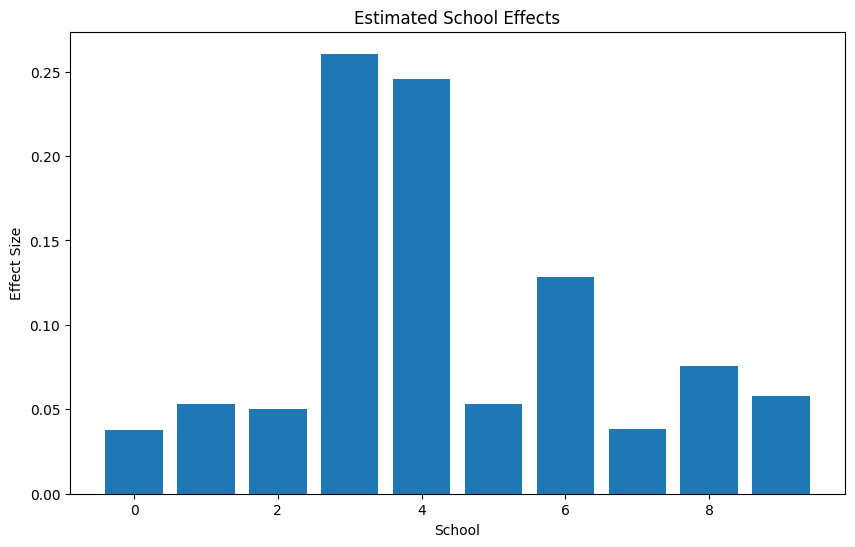

Mean squared error: 22.54
R-squared score: 0.02


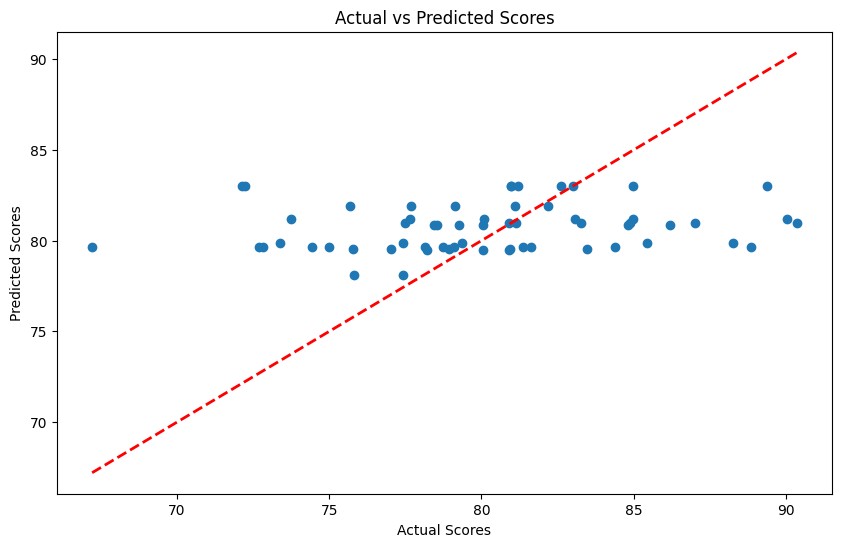

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
n_schools = 10
n_students_per_school = 30
school_effects = np.random.normal(loc=0, scale=1, size=n_schools)
student_effects = np.random.normal(loc=0, scale=1, size=n_students_per_school * n_schools)
student_scores = np.random.normal(loc=80 + school_effects.repeat(n_students_per_school) + student_effects, scale=5)

# Create a DataFrame
data = pd.DataFrame({
    'school': np.repeat(range(n_schools), n_students_per_school),
    'score': student_scores
})

# One-hot encode the school variable
X = pd.get_dummies(data['school'], prefix='school')
y = data['score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate feature importances (which can be interpreted as school effects)
school_effects = rf_model.feature_importances_

# Plot school effects
plt.figure(figsize=(10, 6))
plt.bar(range(n_schools), school_effects)
plt.title('Estimated School Effects')
plt.xlabel('School')
plt.ylabel('Effect Size')
plt.show()

# Print model performance
from sklearn.metrics import mean_squared_error, r2_score
print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R-squared score: {r2_score(y_test, y_pred):.2f}")

# Plot actual vs predicted scores
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs Predicted Scores')
plt.show()